In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

In [0]:
#K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [0]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

In [0]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [0]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [0]:
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
  #  plt.savefig('images/gan_loss_epoch_%d.png' % epoch)

In [0]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
   # plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

In [0]:
# Save the generator and discriminator networks (and weights) for later use
#def saveModels(epoch):
#    generator.save('models/gan_generator_epoch_%d.h5' % epoch)
#    discriminator.save('models/gan_discriminator_epoch_%d.h5' % epoch)

In [0]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            plotGeneratedImages(e)
       #     saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

  2%|▏         | 8/468 [00:00<00:06, 70.35it/s]

Epochs: 200
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  2%|▏         | 8/468 [00:00<00:06, 70.89it/s]

--------------- Epoch 2 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.09it/s]

--------------- Epoch 3 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.55it/s]

--------------- Epoch 4 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.90it/s]

--------------- Epoch 5 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.07it/s]

--------------- Epoch 6 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.58it/s]

--------------- Epoch 7 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.18it/s]

--------------- Epoch 8 ---------------


  2%|▏         | 8/468 [00:00<00:05, 76.86it/s]

--------------- Epoch 9 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.74it/s]

--------------- Epoch 10 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.14it/s]

--------------- Epoch 11 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.65it/s]

--------------- Epoch 12 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.35it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.52it/s]

--------------- Epoch 14 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.92it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.53it/s]

--------------- Epoch 16 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.65it/s]

--------------- Epoch 17 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.46it/s]

--------------- Epoch 18 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.24it/s]

--------------- Epoch 19 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.87it/s]

--------------- Epoch 20 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.67it/s]

--------------- Epoch 21 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.03it/s]

--------------- Epoch 22 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.26it/s]

--------------- Epoch 23 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.74it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.01it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.32it/s]

--------------- Epoch 26 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.24it/s]

--------------- Epoch 27 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.15it/s]

--------------- Epoch 28 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.61it/s]

--------------- Epoch 29 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.10it/s]

--------------- Epoch 30 ---------------


  2%|▏         | 9/468 [00:00<00:05, 79.91it/s]

--------------- Epoch 31 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.82it/s]

--------------- Epoch 32 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.66it/s]

--------------- Epoch 33 ---------------


  2%|▏         | 8/468 [00:00<00:06, 71.74it/s]

--------------- Epoch 34 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.63it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.14it/s]

--------------- Epoch 36 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.69it/s]

--------------- Epoch 37 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.00it/s]

--------------- Epoch 38 ---------------


  2%|▏         | 9/468 [00:00<00:05, 78.83it/s]

--------------- Epoch 39 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.98it/s]

--------------- Epoch 40 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.23it/s]

--------------- Epoch 41 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.41it/s]

--------------- Epoch 42 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.95it/s]

--------------- Epoch 43 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.17it/s]

--------------- Epoch 44 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.53it/s]

--------------- Epoch 45 ---------------


  1%|▏         | 7/468 [00:00<00:06, 67.92it/s]

--------------- Epoch 46 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.44it/s]

--------------- Epoch 47 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.95it/s]

--------------- Epoch 48 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.57it/s]

--------------- Epoch 49 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.15it/s]

--------------- Epoch 50 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.14it/s]

--------------- Epoch 51 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.89it/s]

--------------- Epoch 52 ---------------


  2%|▏         | 8/468 [00:00<00:05, 76.96it/s]

--------------- Epoch 53 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.41it/s]

--------------- Epoch 54 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.61it/s]

--------------- Epoch 55 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.20it/s]

--------------- Epoch 56 ---------------


  1%|▏         | 7/468 [00:00<00:06, 68.46it/s]

--------------- Epoch 57 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.24it/s]

--------------- Epoch 58 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.44it/s]

--------------- Epoch 59 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.99it/s]

--------------- Epoch 60 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.88it/s]

--------------- Epoch 61 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.50it/s]

--------------- Epoch 62 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.48it/s]

--------------- Epoch 63 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.45it/s]

--------------- Epoch 64 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.30it/s]

--------------- Epoch 65 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.76it/s]

--------------- Epoch 66 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.01it/s]

--------------- Epoch 67 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.55it/s]

--------------- Epoch 68 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.50it/s]

--------------- Epoch 69 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.52it/s]

--------------- Epoch 70 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.00it/s]

--------------- Epoch 71 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.31it/s]

--------------- Epoch 72 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.40it/s]

--------------- Epoch 73 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.37it/s]

--------------- Epoch 74 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.73it/s]

--------------- Epoch 75 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.13it/s]

--------------- Epoch 76 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.25it/s]

--------------- Epoch 77 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.40it/s]

--------------- Epoch 78 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.78it/s]

--------------- Epoch 79 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.45it/s]

--------------- Epoch 80 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.89it/s]

--------------- Epoch 81 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.57it/s]

--------------- Epoch 82 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.98it/s]

--------------- Epoch 83 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.20it/s]

--------------- Epoch 84 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.55it/s]

--------------- Epoch 85 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.06it/s]

--------------- Epoch 86 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.57it/s]

--------------- Epoch 87 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.81it/s]

--------------- Epoch 88 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.45it/s]

--------------- Epoch 89 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.91it/s]

--------------- Epoch 90 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.80it/s]

--------------- Epoch 91 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.32it/s]

--------------- Epoch 92 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.38it/s]

--------------- Epoch 93 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.19it/s]

--------------- Epoch 94 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.12it/s]

--------------- Epoch 95 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.27it/s]

--------------- Epoch 96 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.84it/s]

--------------- Epoch 97 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.46it/s]

--------------- Epoch 98 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.11it/s]

--------------- Epoch 99 ---------------


  2%|▏         | 9/468 [00:00<00:05, 85.08it/s]

--------------- Epoch 100 ---------------


  2%|▏         | 9/468 [00:00<00:05, 79.60it/s]

--------------- Epoch 101 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.68it/s]

--------------- Epoch 102 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.77it/s]

--------------- Epoch 103 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.82it/s]

--------------- Epoch 104 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.40it/s]

--------------- Epoch 105 ---------------


  2%|▏         | 8/468 [00:00<00:05, 76.86it/s]

--------------- Epoch 106 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.63it/s]

--------------- Epoch 107 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.55it/s]

--------------- Epoch 108 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.63it/s]

--------------- Epoch 109 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.61it/s]

--------------- Epoch 110 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.93it/s]

--------------- Epoch 111 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.59it/s]

--------------- Epoch 112 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.07it/s]

--------------- Epoch 113 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.37it/s]

--------------- Epoch 114 ---------------


  2%|▏         | 9/468 [00:00<00:05, 79.13it/s]

--------------- Epoch 115 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.70it/s]

--------------- Epoch 116 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.53it/s]

--------------- Epoch 117 ---------------


  2%|▏         | 9/468 [00:00<00:05, 78.16it/s]

--------------- Epoch 118 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.48it/s]

--------------- Epoch 119 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.06it/s]

--------------- Epoch 120 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.76it/s]

--------------- Epoch 121 ---------------


  2%|▏         | 9/468 [00:00<00:05, 78.44it/s]

--------------- Epoch 122 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.06it/s]

--------------- Epoch 123 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.18it/s]

--------------- Epoch 124 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.28it/s]

--------------- Epoch 125 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.73it/s]

--------------- Epoch 126 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.33it/s]

--------------- Epoch 127 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.26it/s]

--------------- Epoch 128 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.49it/s]

--------------- Epoch 129 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.84it/s]

--------------- Epoch 130 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.20it/s]

--------------- Epoch 131 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.37it/s]

--------------- Epoch 132 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.18it/s]

--------------- Epoch 133 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.96it/s]

--------------- Epoch 134 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.95it/s]

--------------- Epoch 135 ---------------


  2%|▏         | 9/468 [00:00<00:05, 79.67it/s]

--------------- Epoch 136 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.52it/s]

--------------- Epoch 137 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.03it/s]

--------------- Epoch 138 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.42it/s]

--------------- Epoch 139 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.66it/s]

--------------- Epoch 140 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.38it/s]

--------------- Epoch 141 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.68it/s]

--------------- Epoch 142 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.22it/s]

--------------- Epoch 143 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.26it/s]

--------------- Epoch 144 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.63it/s]

--------------- Epoch 145 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.75it/s]

--------------- Epoch 146 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.36it/s]

--------------- Epoch 147 ---------------


  2%|▏         | 9/468 [00:00<00:05, 78.91it/s]

--------------- Epoch 148 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.00it/s]

--------------- Epoch 149 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.49it/s]

--------------- Epoch 150 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.55it/s]

--------------- Epoch 151 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.68it/s]

--------------- Epoch 152 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.84it/s]

--------------- Epoch 153 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.34it/s]

--------------- Epoch 154 ---------------


  2%|▏         | 9/468 [00:00<00:05, 85.13it/s]

--------------- Epoch 155 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.53it/s]

--------------- Epoch 156 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.28it/s]

--------------- Epoch 157 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.21it/s]

--------------- Epoch 158 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.18it/s]

--------------- Epoch 159 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.75it/s]

--------------- Epoch 160 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.68it/s]

--------------- Epoch 161 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.06it/s]

--------------- Epoch 162 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.75it/s]

--------------- Epoch 163 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.49it/s]

--------------- Epoch 164 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.50it/s]

--------------- Epoch 165 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.05it/s]

--------------- Epoch 166 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.19it/s]

--------------- Epoch 167 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.76it/s]

--------------- Epoch 168 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.84it/s]

--------------- Epoch 169 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.71it/s]

--------------- Epoch 170 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.25it/s]

--------------- Epoch 171 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.44it/s]

--------------- Epoch 172 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.22it/s]

--------------- Epoch 173 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.99it/s]

--------------- Epoch 174 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.44it/s]

--------------- Epoch 175 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.99it/s]

--------------- Epoch 176 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.00it/s]

--------------- Epoch 177 ---------------


  2%|▏         | 9/468 [00:00<00:05, 79.56it/s]

--------------- Epoch 178 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.26it/s]

--------------- Epoch 179 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.47it/s]

--------------- Epoch 180 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.22it/s]

--------------- Epoch 181 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.53it/s]

--------------- Epoch 182 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.56it/s]

--------------- Epoch 183 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.94it/s]

--------------- Epoch 184 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.63it/s]

--------------- Epoch 185 ---------------


  2%|▏         | 8/468 [00:00<00:05, 76.97it/s]

--------------- Epoch 186 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.01it/s]

--------------- Epoch 187 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.10it/s]

--------------- Epoch 188 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.69it/s]

--------------- Epoch 189 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.33it/s]

--------------- Epoch 190 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.47it/s]

--------------- Epoch 191 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.19it/s]

--------------- Epoch 192 ---------------


  1%|▏         | 7/468 [00:00<00:07, 65.85it/s]

--------------- Epoch 193 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.79it/s]

--------------- Epoch 194 ---------------


  2%|▏         | 8/468 [00:00<00:06, 74.98it/s]

--------------- Epoch 195 ---------------


  1%|▏         | 7/468 [00:00<00:06, 69.24it/s]

--------------- Epoch 196 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.68it/s]

--------------- Epoch 197 ---------------


  2%|▏         | 9/468 [00:00<00:05, 85.35it/s]

--------------- Epoch 198 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.44it/s]

--------------- Epoch 199 ---------------


  2%|▏         | 9/468 [00:00<00:05, 86.20it/s]

--------------- Epoch 200 ---------------


100%|██████████| 468/468 [00:06<00:00, 77.73it/s]


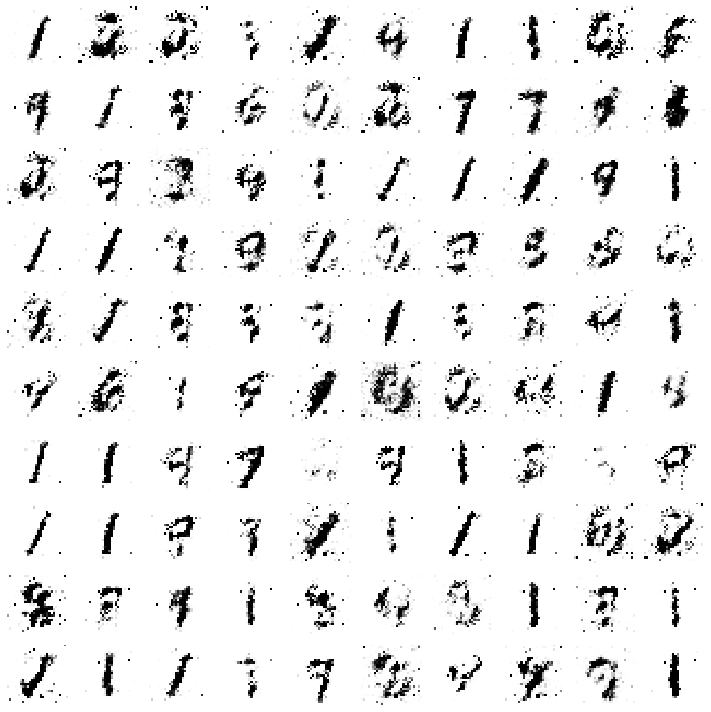

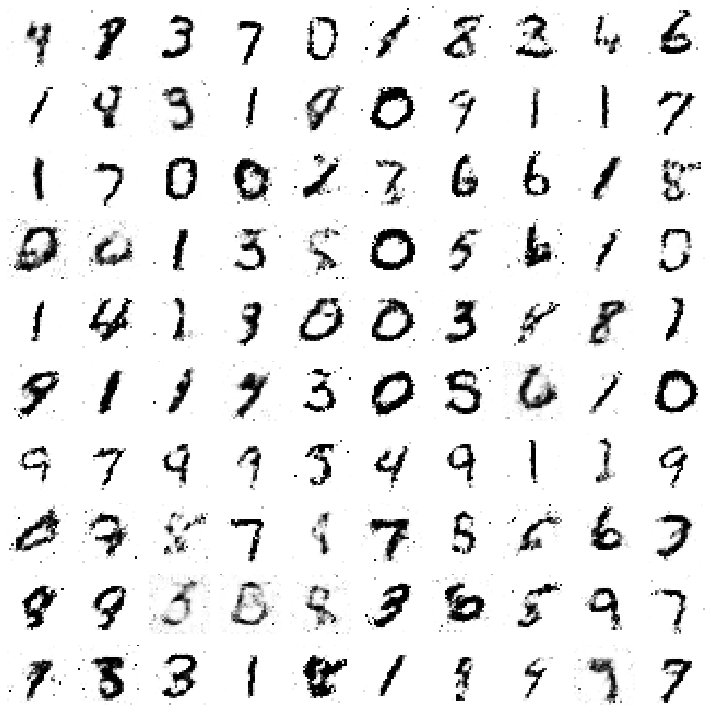

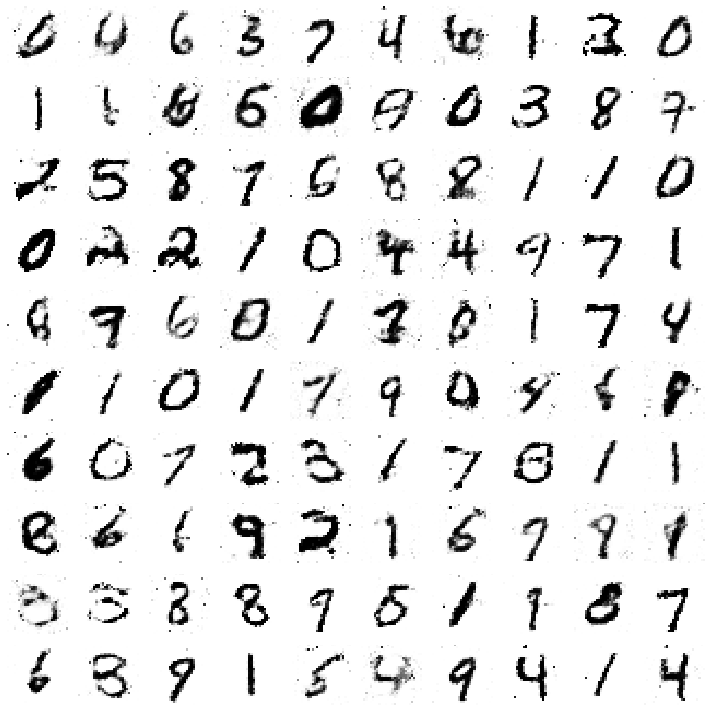

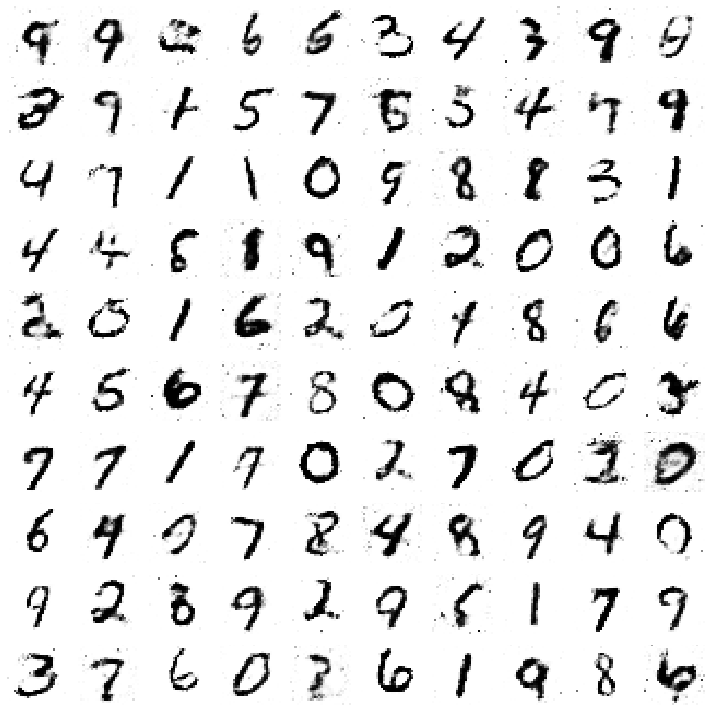

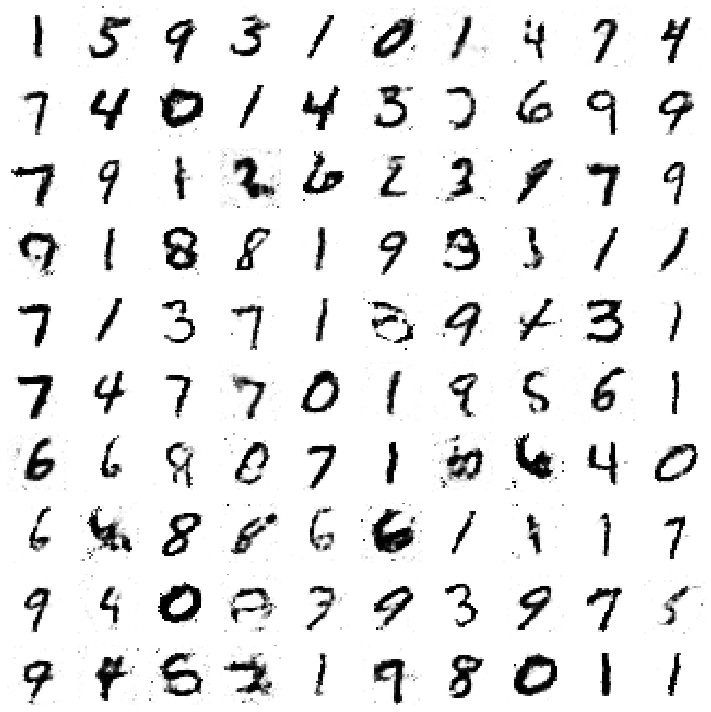

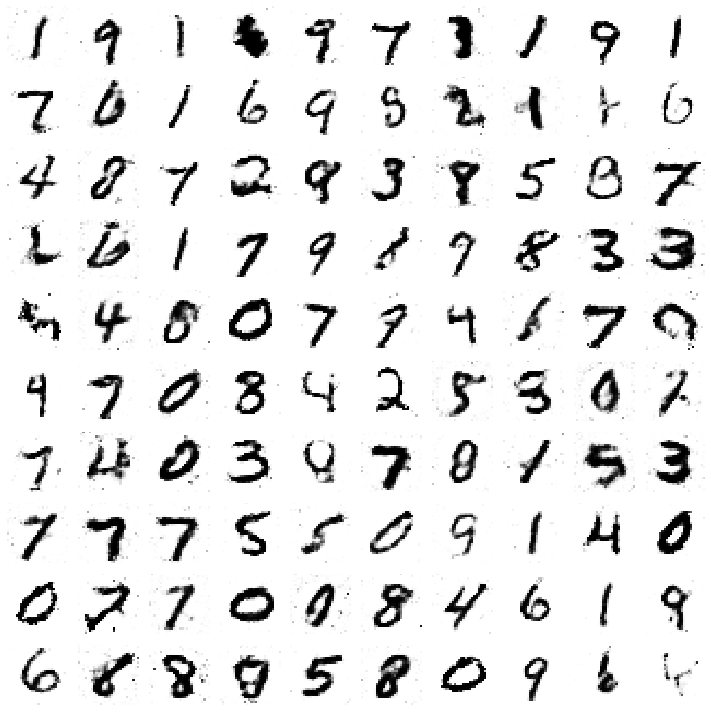

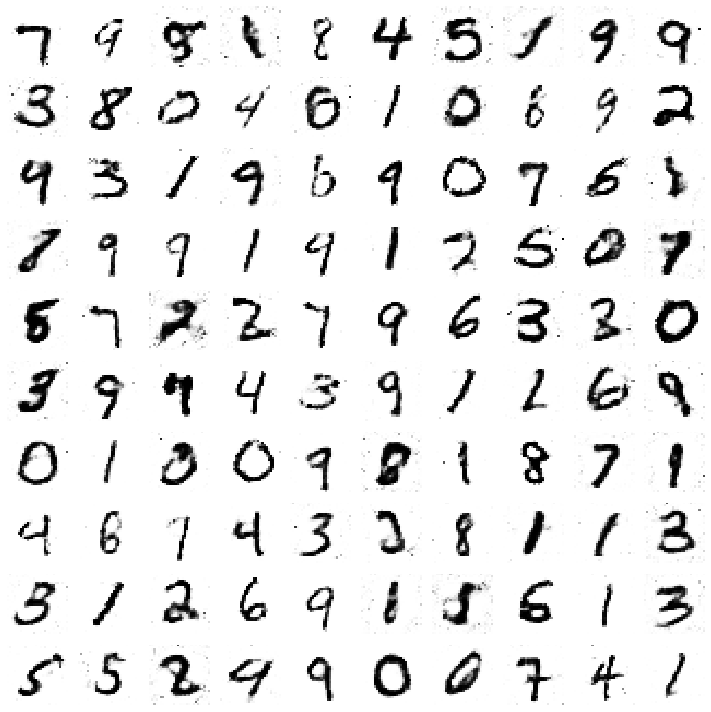

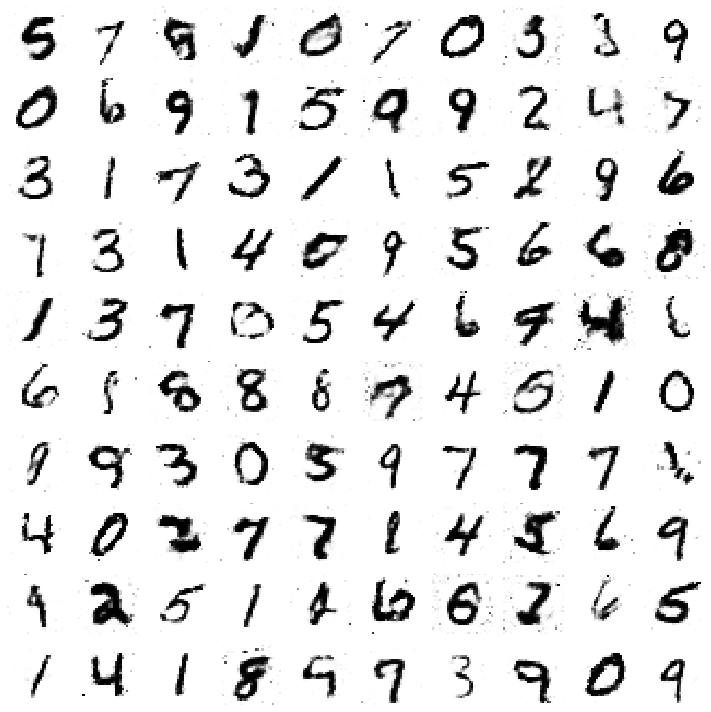

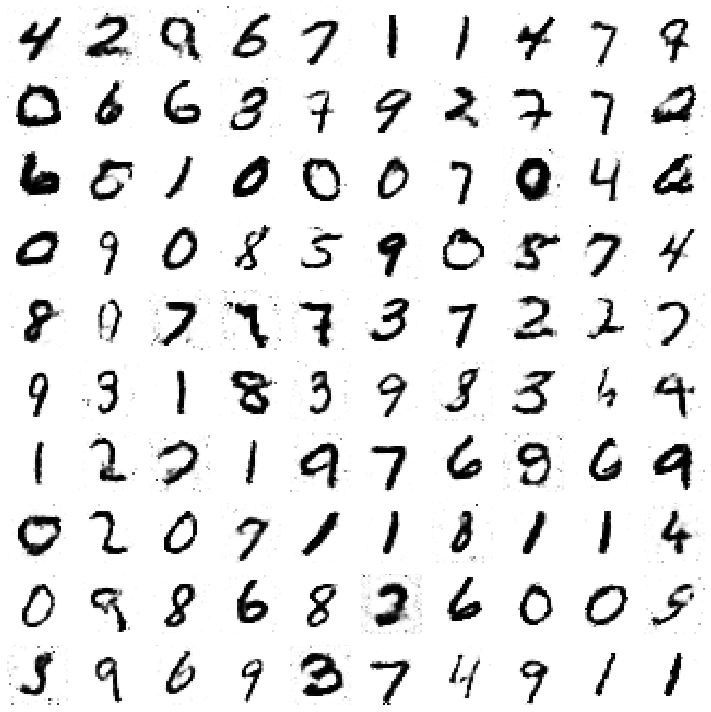

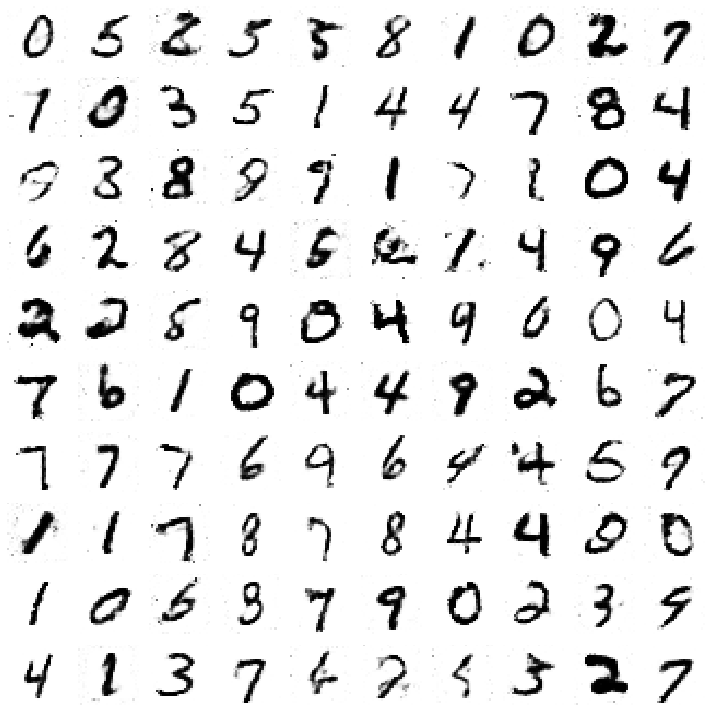

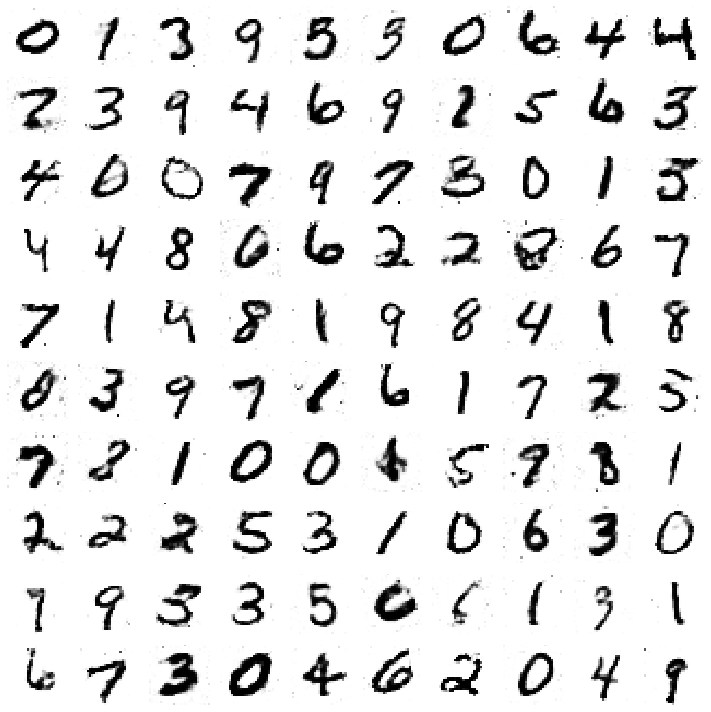

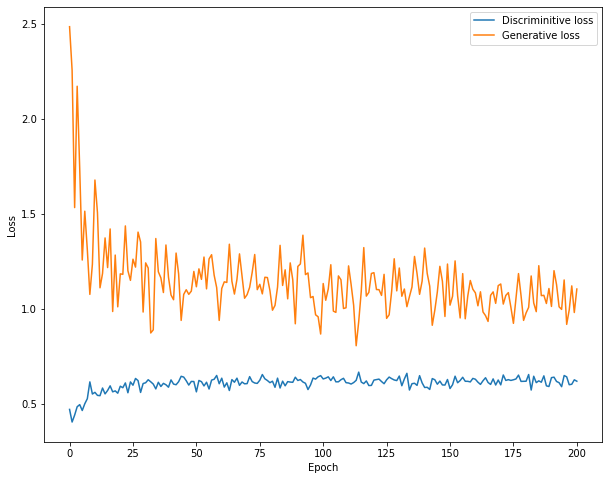

In [0]:
train(200, 128)